In [77]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           balanced_accuracy_score, f1_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
import joblib

# Advanced ML libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available. Install with: pip install lightgbm")

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
print(f"SHAP available: {SHAP_AVAILABLE}")


Libraries imported successfully!
XGBoost available: True
LightGBM available: True
SHAP available: True


In [78]:
# Load preprocessed datasets
print("LOADING PREPROCESSED DATA")

try:
    # Load preprocessed datasets
    X_train = pd.read_csv('X_train_scaled.csv')
    X_val = pd.read_csv('X_val_scaled.csv')
    X_test = pd.read_csv('X_test_scaled.csv')
    
    y_train = pd.read_csv('y_train.csv').squeeze()
    y_val = pd.read_csv('y_val.csv').squeeze()
    y_test = pd.read_csv('y_test.csv').squeeze()
    ### The .squeeze() method removes dimensions of size 1, converting a DataFrame to a Series
    ### The .squeeze() method is a clean, robust way to ensure your target variables are in the correct 1D format that sklearn expects, 
    ### preventing potential errors during model training and evaluation.
    
    # Load preprocessing objects
    scaler = joblib.load('scaler.pkl')
    selected_features = joblib.load('selected_features.pkl')
    
    print("...Preprocessed data loaded successfully!!....")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Display class distribution
    print("\nClass distribution:")
    print("Training set:")
    print(y_train.value_counts().sort_index())
    print("\nValidation set:")
    print(y_val.value_counts().sort_index())
    print("\nTest set:")
    print(y_test.value_counts().sort_index())
    
    # Display selected features
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")
        
except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please run the preprocessing notebook first to generate the required files.")
    print("Required files: X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
    print("                y_train.csv, y_val.csv, y_test.csv")
    print("                scaler.pkl, selected_features.pkl")


LOADING PREPROCESSED DATA
...Preprocessed data loaded successfully!!....
Training set: (368, 5)
Validation set: (123, 5)
Test set: (123, 5)

Class distribution:
Training set:
Loan_Status
0    115
1    253
Name: count, dtype: int64

Validation set:
Loan_Status
0    39
1    84
Name: count, dtype: int64

Test set:
Loan_Status
0    38
1    85
Name: count, dtype: int64

Selected features (5):
 1. Credit_History
 2. Married
 3. Education
 4. TotalIncome
 5. Income_Loan_Ratio


#### **2. Baseline Model - Logistic Regression**


In [79]:
# Baseline Logistic Regression model
print("BASELINE LOGISTIC REGRESSION MODEL")
print("EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction")

# Create and train baseline model
baseline_model = LogisticRegression(
    random_state=234,
    max_iter=100,
    class_weight='balanced'  # Handle class imbalance as recommended by EDA
)

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions
y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)
y_test_pred = baseline_model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
val_balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
val_f1 = f1_score(y_val, y_val_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\nBaseline Model Performance:")
print(f"Training - Accuracy: {train_accuracy:.3f}, Balanced Acc: {train_balanced_acc:.3f}, Macro F1: {train_f1:.3f}")
print(f"Validation - Accuracy: {val_accuracy:.3f}, Balanced Acc: {val_balanced_acc:.3f}, Macro F1: {val_f1:.3f}")
print(f"Test - Accuracy: {test_accuracy:.3f}, Balanced Acc: {test_balanced_acc:.3f}, Macro F1: {test_f1:.3f}")

# Display feature coefficients (interpretability)
print(f"\nFeature Coefficients (Top 10):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:.3f}")

# Store baseline results
baseline_results = {
    'model': 'Logistic Regression',
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_acc': train_balanced_acc,
    'val_balanced_acc': val_balanced_acc,
    'test_balanced_acc': test_balanced_acc,
    'train_f1': train_f1,
    'val_f1': val_f1,
    'test_f1': test_f1
}

print(".... Baseline model completed!")


BASELINE LOGISTIC REGRESSION MODEL
EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction

Baseline Model Performance:
Training - Accuracy: 0.785, Balanced Acc: 0.699, Macro F1: 0.717
Validation - Accuracy: 0.748, Balanced Acc: 0.664, Macro F1: 0.676
Test - Accuracy: 0.797, Balanced Acc: 0.744, Macro F1: 0.753

Feature Coefficients (Top 10):
 1. Credit_History: 1.176
 2. Education: 0.240
 3. Married: 0.190
 4. TotalIncome: -0.142
 5. Income_Loan_Ratio: 0.048
.... Baseline model completed!


#### **3. Random Forest Classifier (EDA Recommendation)**

RANDOM FOREST CLASSIFIER
EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers

Random Forest Performance:
Training - Accuracy: 0.837, Balanced Acc: 0.765, Macro F1: 0.789
Validation - Accuracy: 0.756, Balanced Acc: 0.663, Macro F1: 0.677
Test - Accuracy: 0.870, Balanced Acc: 0.833, Macro F1: 0.843

Feature Importance (Top 10):
 1. Credit_History: 0.538
 2. TotalIncome: 0.213
 3. Income_Loan_Ratio: 0.204
 4. Education: 0.030
 5. Married: 0.015


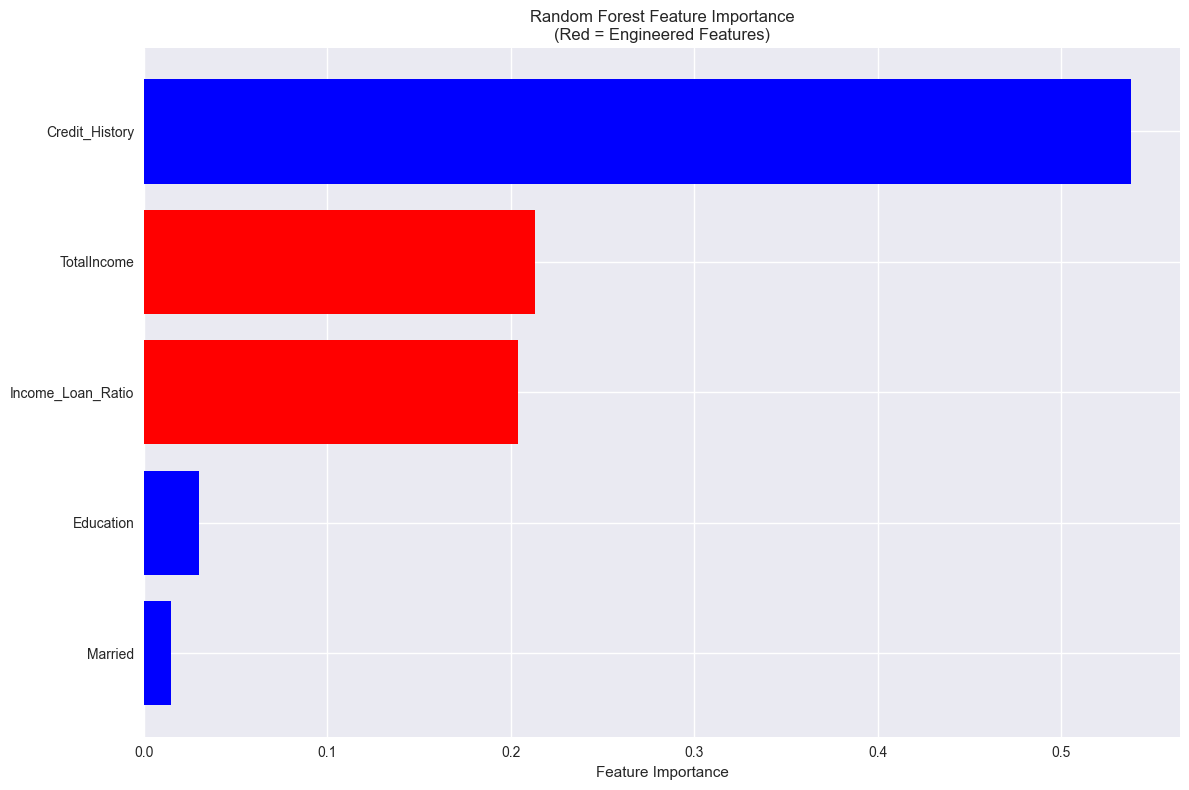

....Random Forest model completed...!


In [80]:
# Random Forest Classifier
print("RANDOM FOREST CLASSIFIER")
print("EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers")

# Create Random Forest model
# rf_model = RandomForestClassifier(
#     n_estimators=100,
#     random_state=42,
#     class_weight='balanced',  # Handle class imbalance
#     n_jobs=-1  # Use all available cores
# )

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,        # number of trees
    max_depth=5,             # limit tree depth
    min_samples_split=5,     # require more samples to split a node
    min_samples_leaf=4,      # require more samples at leaf nodes
    max_features='sqrt',     # limit number of features per split
    class_weight='balanced', # handle class imbalance
    random_state=42,
    n_jobs=-1                # Use all available cores
)


# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

train_balanced_acc_rf = balanced_accuracy_score(y_train, y_train_pred_rf)
val_balanced_acc_rf = balanced_accuracy_score(y_val, y_val_pred_rf)
test_balanced_acc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)

train_f1_rf = f1_score(y_train, y_train_pred_rf, average='macro')
val_f1_rf = f1_score(y_val, y_val_pred_rf, average='macro')
test_f1_rf = f1_score(y_test, y_test_pred_rf, average='macro')

print(f"\nRandom Forest Performance:")
print(f"Training - Accuracy: {train_accuracy_rf:.3f}, Balanced Acc: {train_balanced_acc_rf:.3f}, Macro F1: {train_f1_rf:.3f}")
print(f"Validation - Accuracy: {val_accuracy_rf:.3f}, Balanced Acc: {val_balanced_acc_rf:.3f}, Macro F1: {val_f1_rf:.3f}")
print(f"Test - Accuracy: {test_accuracy_rf:.3f}, Balanced Acc: {test_balanced_acc_rf:.3f}, Macro F1: {test_f1_rf:.3f}")

# Feature importance analysis
print(f"\nFeature Importance (Top 10):")
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features_rf['feature']]

plt.barh(range(len(top_features_rf)), top_features_rf['importance'], color=colors)
plt.yticks(range(len(top_features_rf)), top_features_rf['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Store Random Forest results
rf_results = {
    'model': 'Random Forest',
    'train_accuracy': train_accuracy_rf,
    'val_accuracy': val_accuracy_rf,
    'test_accuracy': test_accuracy_rf,
    'train_balanced_acc': train_balanced_acc_rf,
    'val_balanced_acc': val_balanced_acc_rf,
    'test_balanced_acc': test_balanced_acc_rf,
    'train_f1': train_f1_rf,
    'val_f1': val_f1_rf,
    'test_f1': test_f1_rf
}

print("....Random Forest model completed...!")


In [81]:
# # Balanced Random Forest Classifier
# print("Balanced RANDOM FOREST CLASSIFIER")
# print("EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers")

# from imblearn.ensemble import BalancedRandomForestClassifier

# rf_model = BalancedRandomForestClassifier(
#     n_estimators=200,       # number of trees
#     random_state=42,
#     sampling_strategy='auto',  # balances minority automatically
#     max_depth=None,
#     n_jobs=-1
# )

# # Train the model
# rf_model.fit(X_train, y_train)

# # Make predictions
# y_train_pred_rf = rf_model.predict(X_train)
# y_val_pred_rf = rf_model.predict(X_val)
# y_test_pred_rf = rf_model.predict(X_test)

# # Calculate metrics
# train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
# val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
# test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

# train_balanced_acc_rf = balanced_accuracy_score(y_train, y_train_pred_rf)
# val_balanced_acc_rf = balanced_accuracy_score(y_val, y_val_pred_rf)
# test_balanced_acc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)

# train_f1_rf = f1_score(y_train, y_train_pred_rf, average='macro')
# val_f1_rf = f1_score(y_val, y_val_pred_rf, average='macro')
# test_f1_rf = f1_score(y_test, y_test_pred_rf, average='macro')

# print(f"\nRandom Forest Performance:")
# print(f"Training - Accuracy: {train_accuracy_rf:.3f}, Balanced Acc: {train_balanced_acc_rf:.3f}, Macro F1: {train_f1_rf:.3f}")
# print(f"Validation - Accuracy: {val_accuracy_rf:.3f}, Balanced Acc: {val_balanced_acc_rf:.3f}, Macro F1: {val_f1_rf:.3f}")
# print(f"Test - Accuracy: {test_accuracy_rf:.3f}, Balanced Acc: {test_balanced_acc_rf:.3f}, Macro F1: {test_f1_rf:.3f}")

# # Feature importance analysis
# print(f"\nFeature Importance (Top 10):")
# feature_importance_rf = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': rf_model.feature_importances_
# }).sort_values('importance', ascending=False)

# for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
#     print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")

# # Visualize feature importance
# plt.figure(figsize=(12, 8))
# top_features_rf = feature_importance_rf.head(15)
# colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features_rf['feature']]

# plt.barh(range(len(top_features_rf)), top_features_rf['importance'], color=colors)
# plt.yticks(range(len(top_features_rf)), top_features_rf['feature'])
# plt.xlabel('Feature Importance')
# plt.title('Random Forest Feature Importance\n(Red = Engineered Features)')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

# # Store Random Forest results
# rf_results = {
#     'model': 'Random Forest',
#     'train_accuracy': train_accuracy_rf,
#     'val_accuracy': val_accuracy_rf,
#     'test_accuracy': test_accuracy_rf,
#     'train_balanced_acc': train_balanced_acc_rf,
#     'val_balanced_acc': val_balanced_acc_rf,
#     'test_balanced_acc': test_balanced_acc_rf,
#     'train_f1': train_f1_rf,
#     'val_f1': val_f1_rf,
#     'test_f1': test_f1_rf
# }

# print("....Balanced Random Forest model completed...!")


#### **4. XGBoost Classifier (EDA Recommendation)**

In [82]:


print("LABEL ENCODING FOR XGBOOST COMPATIBILITY")
print("XGBoost requires class labels to start from 0, but wine quality starts from 3")

# Create label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit on all target data to ensure consistent encoding
all_y = pd.concat([y_train, y_val, y_test], ignore_index=True)
label_encoder.fit(all_y)

# Transform all target variables
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Original classes: {sorted(y_train.unique())}")
print(f"Encoded classes: {sorted(y_train_encoded)}")
print(f"Class mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Display encoded class distribution
print("\nEncoded class distribution:")
print("Training set:")
unique, counts = np.unique(y_train_encoded, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

print("Validation set:")
unique, counts = np.unique(y_val_encoded, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

print("Test set:")
unique, counts = np.unique(y_test_encoded, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

print("Label encoding completed!")


LABEL ENCODING FOR XGBOOST COMPATIBILITY
XGBoost requires class labels to start from 0, but wine quality starts from 3
Original classes: [np.int64(0), np.int64(1)]
Encoded classes: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0),

In [83]:
# XGBoost Classifier
print(".....XGBOOST CLASSIFIER....")
print("EDA recommendation: Best performance for structured data, handles non-linearity and feature interactions automatically")

if XGBOOST_AVAILABLE:
    # Create XGBoost model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        n_jobs=-1
    )
    
    # Train the model (using encoded labels for XGBoost)
    xgb_model.fit(X_train, y_train_encoded)
    
    # Make predictions
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_val_pred_xgb = xgb_model.predict(X_val)
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # Convert predictions back to original labels for evaluation
    y_train_pred_xgb_original = label_encoder.inverse_transform(y_train_pred_xgb)
    y_val_pred_xgb_original = label_encoder.inverse_transform(y_val_pred_xgb)
    y_test_pred_xgb_original = label_encoder.inverse_transform(y_test_pred_xgb)
    
    # Calculate metrics using original labels
    train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb_original)
    val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb_original)
    test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb_original)
    
    train_balanced_acc_xgb = balanced_accuracy_score(y_train, y_train_pred_xgb_original)
    val_balanced_acc_xgb = balanced_accuracy_score(y_val, y_val_pred_xgb_original)
    test_balanced_acc_xgb = balanced_accuracy_score(y_test, y_test_pred_xgb_original)
    
    train_f1_xgb = f1_score(y_train, y_train_pred_xgb_original, average='macro')
    val_f1_xgb = f1_score(y_val, y_val_pred_xgb_original, average='macro')
    test_f1_xgb = f1_score(y_test, y_test_pred_xgb_original, average='macro')
    
    print(f"\nXGBoost Performance:")
    print(f"Training - Accuracy: {train_accuracy_xgb:.3f}, Balanced Acc: {train_balanced_acc_xgb:.3f}, Macro F1: {train_f1_xgb:.3f}")
    print(f"Validation - Accuracy: {val_accuracy_xgb:.3f}, Balanced Acc: {val_balanced_acc_xgb:.3f}, Macro F1: {val_f1_xgb:.3f}")
    print(f"Test - Accuracy: {test_accuracy_xgb:.3f}, Balanced Acc: {test_balanced_acc_xgb:.3f}, Macro F1: {test_f1_xgb:.3f}")
    
    # Feature importance analysis
    print(f"\nFeature Importance (Top 10):")
    feature_importance_xgb = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    for i, (_, row) in enumerate(feature_importance_xgb.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")
    
    # Store XGBoost results
    xgb_results = {
        'model': 'XGBoost',
        'train_accuracy': train_accuracy_xgb,
        'val_accuracy': val_accuracy_xgb,
        'test_accuracy': test_accuracy_xgb,
        'train_balanced_acc': train_balanced_acc_xgb,
        'val_balanced_acc': val_balanced_acc_xgb,
        'test_balanced_acc': test_balanced_acc_xgb,
        'train_f1': train_f1_xgb,
        'val_f1': val_f1_xgb,
        'test_f1': test_f1_xgb
    }
    
    print("XGBoost model completed!")
    
else:
    print("... XGBoost not available. Skipping XGBoost model.")
    xgb_results = None


.....XGBOOST CLASSIFIER....
EDA recommendation: Best performance for structured data, handles non-linearity and feature interactions automatically

XGBoost Performance:
Training - Accuracy: 1.000, Balanced Acc: 1.000, Macro F1: 1.000
Validation - Accuracy: 0.642, Balanced Acc: 0.587, Macro F1: 0.587
Test - Accuracy: 0.789, Balanced Acc: 0.760, Macro F1: 0.756

Feature Importance (Top 10):
 1. Credit_History: 0.716
 2. TotalIncome: 0.081
 3. Income_Loan_Ratio: 0.078
 4. Married: 0.065
 5. Education: 0.059
XGBoost model completed!


#### **5. Model Comparison and Evaluation**

MODEL COMPARISON AND EVALUATION

Model Performance Comparison:
Model           Train Acc  Val Acc    Test Acc   Val F1     Test F1   
Logistic Regression 0.785      0.748      0.797      0.676      0.753     
Random Forest   0.837      0.756      0.870      0.677      0.843     
XGBoost         1.000      0.642      0.789      0.587      0.756     

Best Model: Random Forest (Validation F1: 0.677)


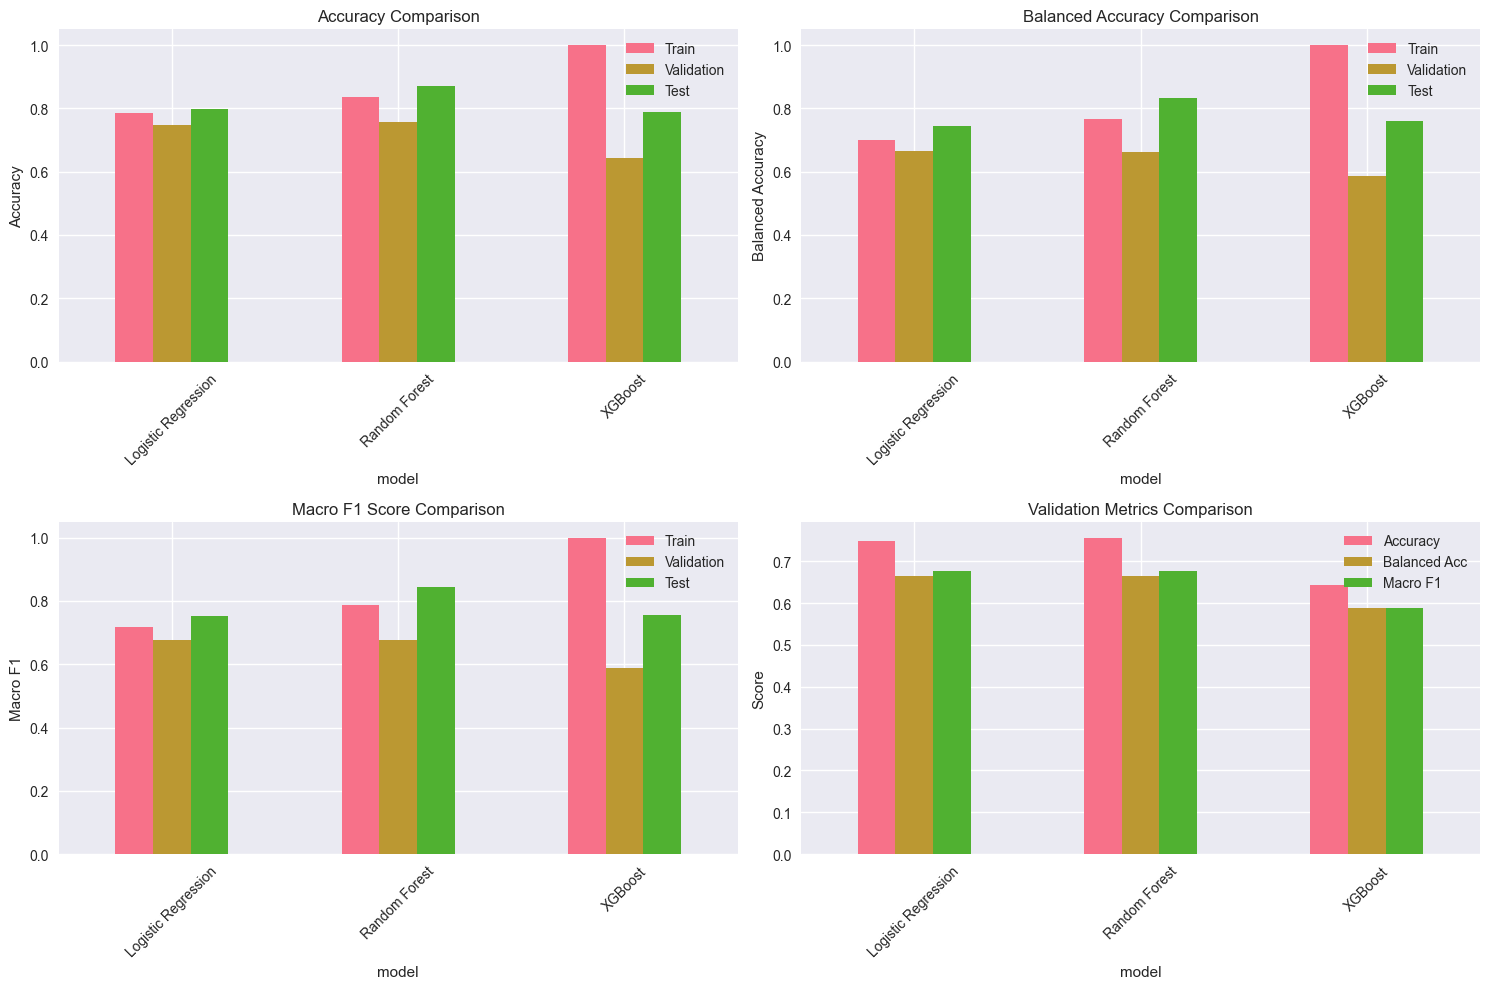

...Model comparison completed!


In [84]:

print("MODEL COMPARISON AND EVALUATION")

# Collect all results
all_results = [baseline_results, rf_results]
if xgb_results is not None:
    all_results.append(xgb_results)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.set_index('model')

print("\nModel Performance Comparison:")
print("=" * 80)
print(f"{'Model':<15} {'Train Acc':<10} {'Val Acc':<10} {'Test Acc':<10} {'Val F1':<10} {'Test F1':<10}")
print("=" * 80)
for _, row in comparison_df.iterrows():
    print(f"{row.name:<15} {row['train_accuracy']:<10.3f} {row['val_accuracy']:<10.3f} {row['test_accuracy']:<10.3f} {row['val_f1']:<10.3f} {row['test_f1']:<10.3f}")

# Find best model based on validation F1 score (EDA recommendation)
best_model_name = comparison_df['val_f1'].idxmax()
best_model_score = comparison_df.loc[best_model_name, 'val_f1']

print(f"\nBest Model: {best_model_name} (Validation F1: {best_model_score:.3f})")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy comparison
comparison_df[['train_accuracy', 'val_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(['Train', 'Validation', 'Test'])
axes[0,0].tick_params(axis='x', rotation=45)

# Balanced Accuracy comparison
comparison_df[['train_balanced_acc', 'val_balanced_acc', 'test_balanced_acc']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Balanced Accuracy Comparison')
axes[0,1].set_ylabel('Balanced Accuracy')
axes[0,1].legend(['Train', 'Validation', 'Test'])
axes[0,1].tick_params(axis='x', rotation=45)

# F1 Score comparison
comparison_df[['train_f1', 'val_f1', 'test_f1']].plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Macro F1 Score Comparison')
axes[1,0].set_ylabel('Macro F1')
axes[1,0].legend(['Train', 'Validation', 'Test'])
axes[1,0].tick_params(axis='x', rotation=45)

# Validation metrics only
validation_metrics = comparison_df[['val_accuracy', 'val_balanced_acc', 'val_f1']]
validation_metrics.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Validation Metrics Comparison')
axes[1,1].set_ylabel('Score')
axes[1,1].legend(['Accuracy', 'Balanced Acc', 'Macro F1'])
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("...Model comparison completed!")


#### **6. Detailed Evaluation of Best Model**

DETAILED EVALUATION OF BEST MODEL
Best Model: Random Forest
Validation F1 Score: 0.677

Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        38
           1       0.89      0.93      0.91        85

    accuracy                           0.87       123
   macro avg       0.86      0.83      0.84       123
weighted avg       0.87      0.87      0.87       123


Confusion Matrix for Random Forest:
[[28 10]
 [ 6 79]]


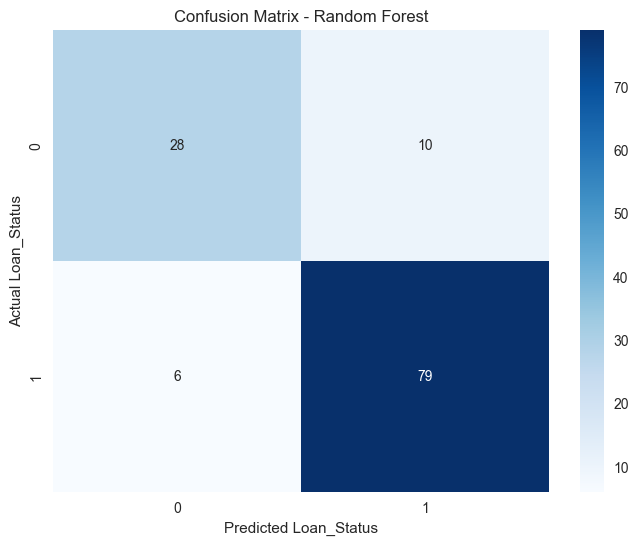


Per-class Performance for Random Forest:
Loan_Status 0: 0.737 accuracy (38 samples)
Loan_Status 1: 0.929 accuracy (85 samples)
...Detailed evaluation completed!


In [85]:
# Detailed evaluation of best model
print("DETAILED EVALUATION OF BEST MODEL")

# Get the best model
if best_model_name == 'Logistic Regression':
    best_model = baseline_model
    y_test_pred_best = y_test_pred
elif best_model_name == 'Random Forest':
    best_model = rf_model
    y_test_pred_best = y_test_pred_rf
elif best_model_name == 'XGBoost':
    best_model = xgb_model
    y_test_pred_best = y_test_pred_xgb

print(f"Best Model: {best_model_name}")
print(f"Validation F1 Score: {best_model_score:.3f}")

# Detailed classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, y_test_pred_best))

# Confusion matrix
print(f"\nConfusion Matrix for {best_model_name}:")
cm = confusion_matrix(y_test, y_test_pred_best)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Loan_Status')
plt.ylabel('Actual Loan_Status')
plt.show()

# Per-class performance
print(f"\nPer-class Performance for {best_model_name}:")
unique_classes = sorted(y_test.unique())
for class_label in unique_classes:
    class_mask = y_test == class_label
    if class_mask.sum() > 0:  # Only if class exists in test set
        class_accuracy = accuracy_score(y_test[class_mask], y_test_pred_best[class_mask])
        print(f"Loan_Status {class_label}: {class_accuracy:.3f} accuracy ({class_mask.sum()} samples)")

print("...Detailed evaluation completed!")


Interpretation

True Negatives (TN) = 28
→ 28 rejected loans were correctly predicted as rejected.

False Positives (FP) = 10
→ 10 rejected loans were incorrectly approved.

False Negatives (FN) = 6
→ 6 approved loans were incorrectly rejected.

True Positives (TP) = 79
→ 79 approved loans were correctly predicted as approved

#### **7. Save Best Model and Results**

In [86]:
# Save best model and results
print("SAVING BEST MODEL AND RESULTS ")

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print(f"- Best model ({best_model_name}) saved as 'best_model.pkl'")

# Save model comparison results
comparison_df.to_csv('model_comparison_results.csv')
print("- Model comparison results saved as 'model_comparison_results.csv'")

# Save detailed results
detailed_results = {
    'best_model': best_model_name,
    'best_model_score': best_model_score,
    'test_accuracy': comparison_df.loc[best_model_name, 'test_accuracy'],
    'test_balanced_acc': comparison_df.loc[best_model_name, 'test_balanced_acc'],
    'test_f1': comparison_df.loc[best_model_name, 'test_f1'],
    'confusion_matrix': cm.tolist(),
    'feature_importance': feature_importance_rf.to_dict('records') if best_model_name == 'Random Forest' else None
}

import json
with open('modeling_results.json', 'w') as f:
    json.dump(detailed_results, f, indent=2)
print("- Detailed results saved as 'modeling_results.json'")

# Save feature importance if available
if hasattr(best_model, 'feature_importances_'):
    feature_importance_best = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    feature_importance_best.to_csv('best_model_feature_importance.csv', index=False)
    print("- Best model feature importance saved as 'best_model_feature_importance.csv'")

print(f"\nMODELING SUMMARY")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {comparison_df.loc[best_model_name, 'test_accuracy']:.3f}")
print(f"Test Balanced Accuracy: {comparison_df.loc[best_model_name, 'test_balanced_acc']:.3f}")
print(f"Test Macro F1: {comparison_df.loc[best_model_name, 'test_f1']:.3f}")

print(f"\nFILES CREATED")
print("- best_model.pkl (trained model)")
print("- model_comparison_results.csv (performance comparison)")
print("- modeling_results.json (detailed results)")
if hasattr(best_model, 'feature_importances_'):
    print("- best_model_feature_importance.csv (feature importance)")

print(f"\nModeling phase completed successfully!")
print("... Ready for model deployment and production use")


SAVING BEST MODEL AND RESULTS 
- Best model (Random Forest) saved as 'best_model.pkl'
- Model comparison results saved as 'model_comparison_results.csv'
- Detailed results saved as 'modeling_results.json'
- Best model feature importance saved as 'best_model_feature_importance.csv'

MODELING SUMMARY
Best Model: Random Forest
Test Accuracy: 0.870
Test Balanced Accuracy: 0.833
Test Macro F1: 0.843

FILES CREATED
- best_model.pkl (trained model)
- model_comparison_results.csv (performance comparison)
- modeling_results.json (detailed results)
- best_model_feature_importance.csv (feature importance)

Modeling phase completed successfully!
... Ready for model deployment and production use


Interpretation

 Strengths

The model accurately identifies most approved loans (79 out of 85) meaning it’s very reliable in granting loans to likely good applicants.

High precision and recall for approvals → fewer “bad approvals”.


Weaknesses

It misses 6 real approvals (False Negatives)  meaning some eligible customers might be wrongly denied, which could hurt customer satisfaction or business opportunities.

It approves 10 unqualified applicants (False Positives) meaning a few risky loans might get approved, increasing potential financial risk.